# ECG abnormality detector

## Authors
Sini Lähde <br>
Omar Nasri <br>
Juuso Torikka

### Objective

Objective of this notebook is to demonstrate arrhythmia 
detection from ECG signals. <br>
This notebook contains all relevant functions 
and functionalities for this project.

In [1]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import biosppy.signals.ecg as ecg
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)
from sklearn.svm import SVC

from typing import Any

/var/folders/py/wrfllc_x5z5bnp2dcbrj_0900000gn/T/ipykernel_27441/2592758454.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
DATA_DIRECTORY = "data_sources"
NORMAL_DATA = "normal"
ABNORMAL_DATA = "abnormal"

In [3]:
def get_file_contents(file_path: str, classification: str) -> pd.DataFrame:
    """Process data file contents.

    Reads data from a specific .csv file and extracts the value column.
    The function splits filename to Subject ID part and and event number.
    These values are added to the dataframe along with classification label.

    Parameters
    ----------
    file_path : str
        Full file path to processed file.
    classification : str
        Classification label of the file.

    Returns
    -------
    pd.DataFrame
        Modified Pandas DataFrame

    """

    file_name = os.path.basename(file_path)
    subject_id, event_number = file_name.replace(".csv", "").split("_")[1:]
    subject_id = subject_id.replace("ID", "")

    data = pd.read_csv(file_path)

    data["event_number"] = event_number
    data["subject_id"] = subject_id
    if classification == NORMAL_DATA:
        data["label"] = 0
        return data
    data["label"] = 1
    return data


def get_directory_contents(directory: str, classification: str) -> pd.DataFrame:
    """Process all files in a directory.

    Iterates over all files in given directory. These files are passed to
    get_file_contents() function, which processes each file. Function combines
    all processed files into one Pandas DataFrame.

    Parameters
    ----------
    directory : str
        Root directory of the source data.
    classification : str
        Subdirectory in root, which indicates to correct classification.

    Returns
    -------
    pd.DataFrame
        Concatenated Pandas DataFrame of all files in same directory.

    """
    full_dataset = []
    directory = os.path.join(directory, classification)
    for file in os.listdir(directory):
        file_path = os.path.join(directory, file)
        data = get_file_contents(file_path=file_path, classification=classification)
        data.shape
        full_dataset.append(data)

    return pd.concat(full_dataset, ignore_index=True)


def combine_all_data() -> pd.DataFrame:
    """Combine all data into one DataFrame

    Functions calls processing tasks to get all the data together
    from their respective directories. Combines all these together.

    Returns
    -------
    pd.DataFrame
        Combined Normal and Abnormal data.

    """

    normal_data = get_directory_contents(DATA_DIRECTORY, NORMAL_DATA)
    print("Normal data has been processed\n")
    abnormal_data = get_directory_contents(DATA_DIRECTORY, ABNORMAL_DATA)
    print("Abnormal data has been processed\n")

    df = pd.concat([normal_data, abnormal_data], ignore_index=True)
    return df.sort_values(["subject_id", "event_number", "label"])

In [4]:
df = combine_all_data()

Normal data has been processed

Abnormal data has been processed



In [5]:
display(df.head())

,Lead II,event_number,subject_id,label
12625200,-0.390,0,100,0
12625201,-0.395,0,100,0
12625202,-0.390,0,100,0
12625203,-0.405,0,100,0
12625204,-0.405,0,100,0


In [6]:
def bandpass_filter(data: np.ndarray, Fs: float) -> np.ndarray:
    """Apply a bandpass Butterworth filter.

    Apply fourth-order Butterworth bandpass filter
    to the input data. Passband of the filter is between 0.5 Hz and 40 Hz

    Parameters
    ----------
    data : np.ndarray
        The input signal data as a numpy array.
    Fs : float
        Sampling frequency.

    Returns
    -------
    np.ndarray
        Filtered signal.

    """

    b, a = sp.signal.butter(4, [0.5, 40], btype="bandpass", fs=Fs)
    w, h = sp.signal.freqz(b, a, fs=Fs)
    return sp.signal.filtfilt(b, a, data)

In [7]:
def apply_z_score(data: np.ndarray) -> np.ndarray:
    """Compute z-score for each value.

    Parameters
    ----------
    data : np.ndarray
        Input data.

    Returns
    -------
    np.ndarray
        Computed z-score array.
    """
    return sp.stats.zscore(data)

In [8]:
# Create a dataframe for feature extraction
Fs = 360
df_features = pd.DataFrame(
    columns=[
        "subject_id",
        "event_number",
        "label",
        "qrs_duration",
        "qrs_amplitude",
        "ST_duration",
        "T_duration",
        "T_amplitude",
        "RR_interval",
    ]
)


def calculate_qrs_durations(
    ecg: np.ndarray, rpeaks: np.ndarray, Fs: int
) -> tuple[float, list]:
    """Calculate mean duration of QRS and S wave starting points.

    ECG signal is smoothed with Savitzky-Golay filter.
    Its derivative is used to find zero crossing before and after each R-peak to help determining QRS duration.

    Parameters
    ----------
    ecg : np.ndarray
        ECG signal.
    rpeaks : np.ndarray
        R-Peaks.
    Fs : int
        Frequency

    Returns
    -------
    tuple[float, list]
        Mean duration of QRS complexes in seconds.
        Start positions of the S waves in seconds.

    """
    filtered_qrs_durations = []
    smoothed_ecg = sp.signal.savgol_filter(ecg, window_length=5, polyorder=3)
    derivative = np.gradient(smoothed_ecg)
    s_wave_start_positions = []
    for i in range(len(rpeaks)):
        rpeak = rpeaks[i]
        j = rpeak
        while j > 0:
            if derivative[j] > 0:
                j -= 1
            else:
                break
        k = rpeak
        while k < len(derivative):
            if derivative[k] < 0:
                k += 1
            else:
                break
        filtered_qrs_durations.append((k - j) / Fs)
        s_wave_start_positions.append(k / Fs)
    return np.mean(filtered_qrs_durations), s_wave_start_positions


def calculate_t_wave_features(
    ecg: np.ndarray, rpeaks: np.ndarray, Fs: int
) -> tuple[float, float, list[float]]:
    """Calculate T-wave features.

    Obtain the means of amplitude and duration and
    start positions of T-waves.

    Parameters
    ----------
    ecg : np.ndarray
        ECG signal..
    rpeaks : np.ndarray
        Signal R-peak indices.
    Fs : int
        Sampling frequency.

    Returns
    -------
    tuple[float, float, list[float]]
        Mean amplitude of T-waves.
        Mean duration of T-waves in seconds.
        Start positions of T-waves in seconds.
    """

    t_amplitudes = []
    t_wave_timestamps = []
    delay_start = int(0.05 * Fs)
    delay_end = int(0.4 * Fs)

    for i in range(len(rpeaks)):
        rpeak = rpeaks[i]
        gap_start = rpeak + delay_start
        gap_end = rpeak + delay_end
        gap_values = ecg[gap_start:gap_end]

        if len(gap_values) == 0:
            continue
        else:
            t_amplitude = np.max(gap_values)
            t_amplitudes.append(t_amplitude)

        max_index = np.argmax(gap_values) + gap_start
        t_wave_timestamps.append(max_index)

    t_wave_timestamps = pd.Series(t_wave_timestamps)
    t_wave_timestamps = t_wave_timestamps[:-1]
    smoothed_ecg = sp.signal.savgol_filter(ecg, window_length=5, polyorder=3)
    derivative = np.gradient(smoothed_ecg)
    t_durations = []
    t_wave_start_positions = []

    for i in range(len(t_wave_timestamps)):
        t_wave = t_wave_timestamps[i]
        j = t_wave - int(0.12 * Fs)

        while j < len(derivative):
            if derivative[j] > 0:
                j += 1
            else:
                break

        k = t_wave + int(0.15 * Fs)
        while k < len(derivative):
            if derivative[k] < 0:
                k += 1
            else:
                break

        t_durations.append((k - j) / Fs)
        t_wave_start_positions.append(j / Fs)

    return np.mean(t_amplitudes), np.mean(t_durations), t_wave_start_positions


def calculate_st_duration(
    t_wave_start_positions: np.ndarray, s_wave_start_positions: np.ndarray
) -> float:
    """
    Calculate the mean ST segment duration

    The ST duration is calculated for each pair of T-wave and S-wave start positions,
    with the mean duration across all calculated differences returned.

    Parameters
    ----------
    t_wave_start_positions : np.ndarray
        T-wave start positions in seconds.
    s_wave_start_positions : np.ndarray
        S-wave start positions in seconds.
    Returns
    -------
    float
        Mean ST segment duration as the average difference between T-wave and S-wave
        start positions.
    """
    st_durations = []
    for i in range(len(t_wave_start_positions)):
        st_durations.append(t_wave_start_positions[i] - s_wave_start_positions[i])
    return np.mean(st_durations)


def extractFeatures(df: pd.DataFrame, Fs: int) -> pd.DataFrame:
    """Extract features from ECG signal.

    Extracts RR intervals, features of QRS complex,
    T-wave features, and ST segment duration.

    This function iterates through 10 second segments of an ECG signal
    and applies a bandpass filter and Z-score normalization,
    detects R-peaks, and calculates necessary features.

    Parameters
    ----------
    df : pd.DataFrame
        Signal to be processed.
    Fs : int
        Sampling rate.

    Returns
    -------
    pd.Dataframe
        DataFrame with extracted features for each segment.

    """

    ten_second_sample = Fs * 10
    iterations = int(len(df) / ten_second_sample)

    for i in range(iterations):
        ecg_signal = df["Lead II"].values[
            i * (ten_second_sample) : (i + 1) * (ten_second_sample)
        ]
        ecg_signal_filtered = bandpass_filter(ecg_signal, Fs)
        ecg_signal_filtered = apply_z_score(ecg_signal_filtered)

        rpeaks = ecg.hamilton_segmenter(signal=ecg_signal_filtered, sampling_rate=Fs)[0]

        rr_interval = np.mean(np.diff(rpeaks / Fs))

        qrs_amplitudes = [ecg_signal_filtered[rpeak] for rpeak in rpeaks]
        qrs_amplitude = np.mean(qrs_amplitudes)
        qrs_duration, s_start = calculate_qrs_durations(ecg_signal_filtered, rpeaks, Fs)

        t_duration, t_amplitude, t_start = calculate_t_wave_features(
            ecg_signal_filtered, rpeaks, Fs
        )

        st_duration = calculate_st_duration(t_start, s_start)

        df_features.loc[i] = [
            df["subject_id"][i * (ten_second_sample)],
            df["event_number"][i * (ten_second_sample)],
            df["label"][i * (ten_second_sample)],
            qrs_duration,
            qrs_amplitude,
            st_duration,
            t_duration,
            t_amplitude,
            rr_interval,
        ]
    return df_features

In [9]:
df_features = extractFeatures(df, Fs)

In [10]:
display(df_features.head())

,subject_id,event_number,label,qrs_duration,qrs_amplitude,ST_duration,T_duration,T_amplitude,RR_interval
0,105,102,0,0.025694,7.027026,0.240909,0.213224,0.271970,0.819192
1,220,95,0,0.024573,6.808983,0.226389,0.208369,0.274306,0.806019
2,115,96,0,0.024537,6.935898,0.231061,0.222428,0.271970,0.807828
3,212,27,0,0.025427,6.759421,0.224769,0.178941,0.266898,0.793056
4,115,116,0,0.024306,6.959680,0.228535,0.192532,0.263131,0.800758


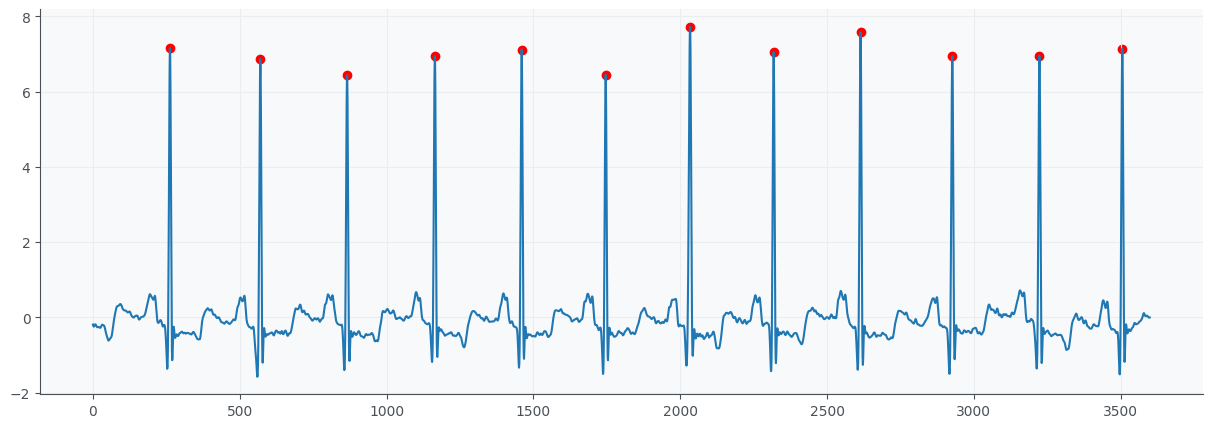

In [11]:
"""Testing the feature calculation.

Creating a test signal, filtering and normalizing it.
Calculate R-peaks and T-peaks.

Plot test signal.
"""

test_ecg = df["Lead II"].values[: 10 * Fs]

test_ecg = bandpass_filter(test_ecg, Fs)

test_ecg = apply_z_score(test_ecg)

rpeaks = ecg.hamilton_segmenter(test_ecg, sampling_rate=Fs)[0]

t_amplitude, t_duration, t = calculate_t_wave_features(test_ecg, rpeaks, Fs)

plt.figure(figsize=(15, 5))
plt.plot(test_ecg)
plt.scatter(rpeaks, test_ecg[rpeaks], c="r")

# Modeling

### Pre-process for models

In [12]:
FEATURES = [
    "qrs_duration",
    "qrs_amplitude",
    "ST_duration",
    "T_duration",
    "T_amplitude",
    "RR_interval",
]
LABEL = "label"

features = df_features[FEATURES].values
labels = df_features[LABEL].values

total_metrics = {
    "SVM-Accuracy": [],
    "SVM-Precision": [],
    "SVM-Recall": [],
    "SVM-F1": [],
    "KNN-Accuracy": [],
    "KNN-Precision": [],
    "KNN-Recall": [],
    "KNN-F1": [],
}

In [13]:
X_train, X_temp, y_train, y_temp = train_test_split(
    features, labels, test_size=0.3, stratify=labels, random_state=42
)
X_test, X_unseen, y_test, y_unseen = train_test_split(
    X_temp, y_temp, test_size=0.3, random_state=42
)

In [14]:
"""Initialize dataframe where predictions are added."""

predictions_df = pd.DataFrame(X_unseen, columns=FEATURES)
predictions_df["true_label"] = y_unseen

In [15]:
def _get_metrics(
    actual: np.ndarray, prediction: np.ndarray
) -> tuple[float, float, float, float, np.ndarray]:
    """Get model metrics.

    Parameters
    ----------
    actual: np.ndarray
        Actual labels.
    prediction: np.ndarray
        Predicted labels.

    Returns
    -------
    tuple[float, float, float, float, np.ndarray]
        Metrics: accuracy, precision, recall, f1, confusion matrix

    """

    accuracy = accuracy_score(actual, prediction)
    precision = precision_score(actual, prediction)
    recall = recall_score(actual, prediction)
    f1 = f1_score(actual, prediction)
    conf_matrix = confusion_matrix(actual, prediction)

    return accuracy, precision, recall, f1, conf_matrix

### Support Vector Machine (SVM)

In [16]:
def get_svm_classifier(X_train: np.ndarray, y_train: np.ndarray) -> SVC:
    """Train an SVM classifier.

    Function trains a SupportVectorMachine classifier with an RBF kernel and evaluates it.

    Parameters
    ----------
    X_train: np.ndarray
        Train features.
    y_train: np.ndarray
        Train labels.

    Returns
    -------
    SVC
        SVM-model

    """

    svm_classifier = SVC(kernel="rbf", random_state=42, gamma="auto", C=13)
    model = svm_classifier.fit(X_train, y_train)

    predictions = model.predict(X_test)

    accuracy, precision, recall, f1, conf_matrix = _get_metrics(y_test, predictions)

    print(
        f"SVM Metrics:\n\
    Accuracy: {accuracy:.4f}\n\
    Precision: {precision:.4f}\n\
    Recall: {recall:.4f}\n\
    F1 Score: {f1:.4f}\n\
    Confusion Matrix:\n{conf_matrix}"
    )

    return model

In [17]:
svm_classifier = get_svm_classifier(X_train, y_train)

SVM Metrics:
    Accuracy: 0.7945
    Precision: 0.7956
    Recall: 0.8096
    F1 Score: 0.8025
    Confusion Matrix:
[[625 178]
 [163 693]]


In [18]:
svm_predictions = svm_classifier.predict(X_unseen)
predictions_df["svm_predicted_label"] = svm_predictions

accuracy, precision, recall, f1, conf_matrix = _get_metrics(y_unseen, svm_predictions)
total_metrics.update(
    {
        "SVM-Accuracy": accuracy,
        "SVM-Precision": precision,
        "SVM-Recall": recall,
        "SVM-F1": f1,
    }
)

print(
    f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1: {f1}\nConfusion Matrix:\n{conf_matrix}"
)

Accuracy: 0.8089887640449438
Precision: 0.8083333333333333
Recall: 0.8128491620111732
F1: 0.8105849582172702
Confusion Matrix:
[[285  69]
 [ 67 291]]


### K-nn classifier

In [19]:
K_VALUES = [1, 3, 5, 7, 9, 11, 13, 15, 17]


def k_nn_classifier(
    X_train: np.ndarray, y_train: np.ndarray, k_values: list[int]
) -> int:
    """Train k-nn classifier.

    Trains K_nearest-neighbor classifier with specified K-values.
    Gets metrics for each k-value and returns the best K which can be used to train a new model.

    Parameters
    ----------
    X_train: np.ndarray
        Train features.
    y_train: np.ndarray
        Train labels.
    k_values: list[int]
        List of specified K-values to iterate.

    Returns
    -------
    int
        Best k-value.
    """
    metrics = {
        "K-value": [],
        "Accuracy": [],
        "Precision": [],
        "Recall": [],
        "F1": [],
    }

    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)

        y_pred = knn.predict(X_test)

        accuracy, precision, recall, f1, _ = _get_metrics(y_test, y_pred)

        metrics["K-value"].append(k)
        metrics["Accuracy"].append(accuracy)
        metrics["Precision"].append(precision)
        metrics["Recall"].append(recall)
        metrics["F1"].append(f1)

    metrics_df = pd.DataFrame(metrics)
    best_k = metrics_df.loc[metrics_df["Recall"].idxmax()]
    best_k = int(best_k["K-value"])

    print(metrics_df)
    print(f"\nBest K-value based on recall: {best_k}")
    return best_k


best_k = k_nn_classifier(X_train, y_train, K_VALUES)

   K-value  Accuracy  Precision    Recall        F1
0        1  0.874020   0.888355  0.864486  0.876258
1        3  0.870404   0.885680  0.859813  0.872555
2        5  0.871609   0.890644  0.856308  0.873139
3        7  0.870404   0.891331  0.852804  0.871642
4        9  0.869198   0.894932  0.845794  0.869670
5       11  0.863773   0.893750  0.835280  0.863527
6       13  0.859554   0.886957  0.834112  0.859723
7       15  0.855937   0.888050  0.824766  0.855239
8       17  0.851115   0.877323  0.827103  0.851473

Best K-value based on recall: 1


In [20]:
knn_final = KNeighborsClassifier(n_neighbors=best_k)
knn_final.fit(X_train, y_train)
knn_predictions = knn_final.predict(X_unseen)

In [21]:
accuracy, precision, recall, f1, conf_matrix = _get_metrics(y_unseen, knn_predictions)
total_metrics.update(
    {
        "KNN-Accuracy": accuracy,
        "KNN-Precision": precision,
        "KNN-Recall": recall,
        "KNN-F1": f1,
    }
)

print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall {recall}\nF1 {f1}")

print(f"\nConfusion Matrix:\n{conf_matrix}")

Accuracy: 0.8651685393258427
Precision: 0.8830409356725146
Recall 0.8435754189944135
F1 0.8628571428571429

Confusion Matrix:
[[314  40]
 [ 56 302]]


In [22]:
predictions_df["k_nn_predicted_label"] = knn_predictions
predictions_df

,qrs_duration,qrs_amplitude,ST_duration,T_duration,T_amplitude,RR_interval,true_label,svm_predicted_label,k_nn_predicted_label
0,0.042037,4.488716,0.228373,1.466010,0.150198,0.674206,1,1,1
1,0.028993,3.886879,0.120926,1.404890,0.255185,0.630556,1,1,1
2,0.038095,4.465087,0.219444,0.712549,0.260043,0.690385,0,0,0
3,0.025000,6.574189,0.176282,0.572939,0.268590,0.721154,1,1,1
4,0.021759,5.784955,0.061869,0.364909,0.270202,0.827525,1,1,1
...,...,...,...,...,...,...,...,...,...
707,0.055324,2.432740,0.300758,1.533862,0.161869,0.829798,1,0,0
708,0.031389,7.193404,0.198457,0.871768,0.241667,0.924383,1,0,1
709,0.045455,5.169972,0.272778,0.425073,0.190833,0.846667,0,0,1
710,0.053395,5.124924,0.131597,0.802216,0.263542,1.022917,0,0,0


In [23]:
total_metrics

{'SVM-Accuracy': 0.8089887640449438,
 'SVM-Precision': 0.8083333333333333,
 'SVM-Recall': 0.8128491620111732,
 'SVM-F1': 0.8105849582172702,
 'KNN-Accuracy': 0.8651685393258427,
 'KNN-Precision': 0.8830409356725146,
 'KNN-Recall': 0.8435754189944135,
 'KNN-F1': 0.8628571428571429}